<a href="https://colab.research.google.com/github/OmidGhadami95/Geolife-OutlierDetection-TMD/blob/main/Geolife_Outlierdetection_TMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Notice:
- Use IQR or z-score not both
- Perhaps we need just one prune (acceleration or velocity. not both)
- Tune z-score hyperparameter (threshold)
- This part must perform before calculating aggregated features


In [ ]:
!pip3 install pyproj
import pandas as pd
import datetime as dt
import pyproj
import numpy as np
import os
from multiprocessing.pool import Pool
import time
from IPython.display import display, HTML
import glob
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Loading Data from csv to dataframes**

In [ ]:
def clean_label(label):
    return label.lstrip(',').rstrip(',').replace(',,', ',')

INPUT_FOLDER = '/content/drive/MyDrive/processed_data/020.csv'
headers_metadf = ['trajectory_id', 'start_time', 'end_time', 'v_ave', 'v_med', 'v_max', 'a_ave', 'a_med', 'a_max', 'labels']

df = pd.read_csv(INPUT_FOLDER,index_col=0)
df_labeled = df.dropna(subset=['acceleration','velocity','v_ave','v_med','v_max', 'a_ave', 'a_med', 'a_max', 'labels']) #!!!!!MODIFIED!!!!!
df_labeled.loc[:,'labels'] = df_labeled['labels'].apply(lambda x: clean_label(x))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
df_labeled.head()

,lat,long,altitude,datetime,timedelta,distance,velocity,acceleration,trajectory_id,subfolder,labels,v_ave,v_med,v_max,a_ave,a_med,a_max
0,39.981590,116.327578,0,2011-11-25 01:44:22,0 days 00:00:01,3.712078,3.712078,-3.335068,20111125014422,20,bike,3.48697,3.187125,52.872515,-0.089624,-0.042987,13.862124
1,39.981557,116.327582,0,2011-11-25 01:44:23,0 days 00:00:56,21.112585,0.377010,0.937420,20111125014422,20,bike,3.48697,3.187125,52.872515,-0.089624,-0.042987,13.862124
2,39.981382,116.327678,0,2011-11-25 01:45:19,0 days 00:00:01,52.872515,52.872515,-51.941601,20111125014422,20,bike,3.48697,3.187125,52.872515,-0.089624,-0.042987,13.862124
3,39.980920,116.327830,0,2011-11-25 01:45:20,0 days 00:00:01,0.930914,0.930914,7.179167,20111125014422,20,bike,3.48697,3.187125,52.872515,-0.089624,-0.042987,13.862124
4,39.980923,116.327820,0,2011-11-25 01:45:21,0 days 00:00:01,8.110082,8.110082,-4.270712,20111125014422,20,bike,3.48697,3.187125,52.872515,-0.089624,-0.042987,13.862124


In [ ]:
before_outlier = len(df_labeled.index.unique())

In [ ]:
df_labeled.labels.unique()

array(['bike', 'walk', 'bus', 'subway', 'train', 'car'], dtype=object)

In [ ]:
df_bike = df_labeled.loc[df_labeled.labels=='bike']

In [ ]:
df_walk = df_labeled.loc[df_labeled.labels=='walk']

In [ ]:
df_bus = df_labeled.loc[df_labeled.labels=='bus']

In [ ]:
df_subway = df_labeled.loc[df_labeled.labels=='subway']

In [ ]:
df_train = df_labeled.loc[df_labeled.labels=='train']

In [ ]:
df_car = df_labeled.loc[df_labeled.labels=='car']

## **How many samples in each class does it have?**

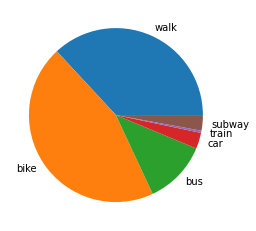

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_list = ["walk", "bike", "bus", "car", "train", "subway"]
y = np.array([len(df_walk), len(df_bike), len(df_bus), len(df_car), len(df_subway), len(df_train)])

plt.pie(y, labels=class_list)
plt.show()

# **Outlier detecting and removing for all classes on acceleration and velocity columns**

## **Main Functions**

In [ ]:
# IQR (Interquartile range)
# this function delete records which are higher than Q3+1.5*IQR in a specific column (Upper bound)

def IQRmethod(df, column):
  print('your dataframe has', len(df[column]), 'records')
  Q1 = np.percentile(df[column], 25, interpolation = 'midpoint')
  Q3 = np.percentile(df[column], 75, interpolation = 'midpoint')
  IQR = Q3 - Q1
  if column == 'velocity':
    df = df[df[column] < (Q3+1.5*IQR)]
  elif column == 'acceleration':
    df = df[df[column] < (Q3+1.5*IQR)]
    df = df[df[column] > (Q1-1.5*IQR)]
  print('your dataframe has', len(df[column]), 'records after omit upper baound for' , column)
  return df

In [ ]:
# z-score
#this function delete records which are higher than +4 z-score in a specific column (threshold)

def ZS(df, column, threshold):
  print('your dataframe has', len(df[column]), 'records')
  s = sum(df[column])
  mean = s / len(df[column])
  d = [(each - mean)**2 for each in df[column]]
  sum_d = sum(d)
  standard_deviation = (sum_d / (len(df[column]) - 1)) ** 0.5
  z_score = [(each - mean)/standard_deviation for each in df[column]]
  se = pd.Series(z_score)
  #df['z_score'] = se.values
  df.loc[:,'z_score'] = se    ##################################################????????????????????????????????????????????
  if column == 'velocity':
    df.drop(df[df['z_score'] >= threshold].index, inplace = True)
  elif column == 'acceleration':
    df.drop(df[df['z_score'] >= threshold].index, inplace = True)
    df.drop(df[df['z_score'] <= -threshold].index, inplace = True)
  df = df.drop(['z_score'], axis=1)
  print('your dataframe has', len(df[column]), 'records after omit upper baound for' , column)
  return df

## **1- walk**

### **1-A) box plot before omit outliers**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


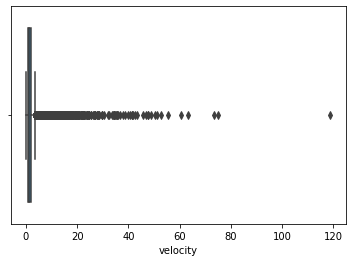

In [ ]:
# velocity

sns.boxplot(df_walk['velocity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


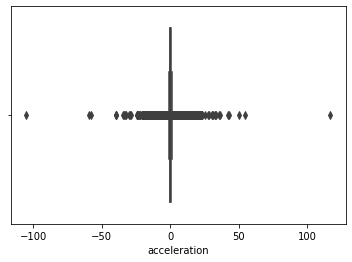

In [ ]:
#acceleration

sns.boxplot(df_walk['acceleration'])

### **1-B) IQR**

In [ ]:
df_walk = IQRmethod(df_walk,'velocity')
df_walk = IQRmethod(df_walk,'acceleration')

your dataframe has 52098 records
your dataframe has 48503 records after omit upper baound for velocity
your dataframe has 48503 records
your dataframe has 43342 records after omit upper baound for acceleration


### **1-C) z-score**

In [ ]:
df_walk = ZS(df_walk,'velocity',3)
df_walk = ZS(df_walk,'acceleration',3)

your dataframe has 43342 records
your dataframe has 43148 records after omit upper baound for velocity
your dataframe has 43148 records
your dataframe has 43148 records after omit upper baound for acceleration


### **1-D) box plot after omit outliers**


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


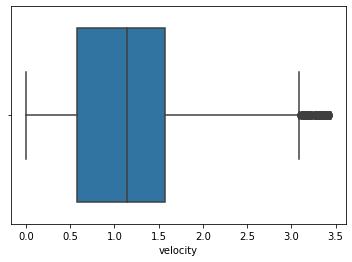

In [ ]:
# velocity

sns.boxplot(df_walk['velocity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


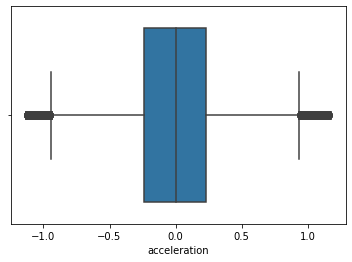

In [ ]:
#acceleration

sns.boxplot(df_walk['acceleration'])

## **2) bike**

### **2-A) box plot before omit outliers**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


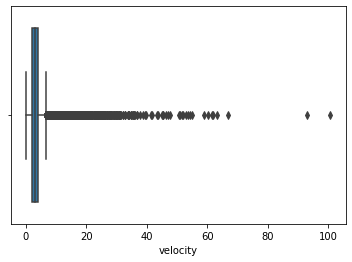

In [ ]:
# velocity

sns.boxplot(df_bike['velocity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


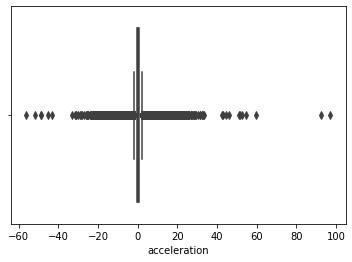

In [ ]:
#acceleration

sns.boxplot(df_bike['acceleration'])

### **2-B) IQR**

In [ ]:
df_bike = IQRmethod(df_bike,'velocity')
df_bike = IQRmethod(df_bike,'acceleration')

your dataframe has 63622 records
your dataframe has 60915 records after omit upper baound for velocity
your dataframe has 60915 records
your dataframe has 54355 records after omit upper baound for acceleration


### **2-C) z-score**

In [ ]:
df_bike = ZS(df_bike,'velocity',3)
df_bike = ZS(df_bike,'acceleration',3)

your dataframe has 54355 records
your dataframe has 54355 records after omit upper baound for velocity
your dataframe has 54355 records
your dataframe has 54355 records after omit upper baound for acceleration


### **2-D) box plot after omit outliers**




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


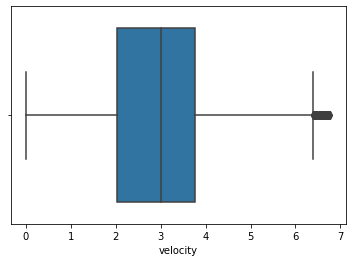

In [ ]:
# velocity

sns.boxplot(df_bike['velocity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


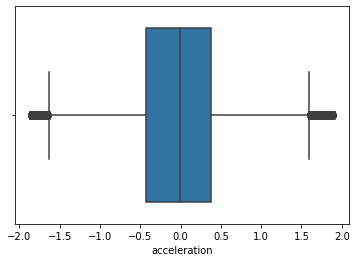

In [ ]:
#acceleration

sns.boxplot(df_bike['acceleration'])

## **3) bus**

### **3-A) box plot before omit outliers**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


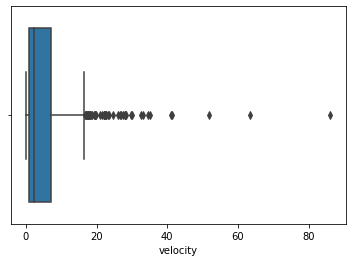

In [ ]:
# velocity

sns.boxplot(df_bus['velocity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


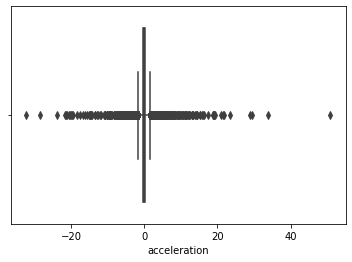

In [ ]:
# acceleration

sns.boxplot(df_bus['acceleration'])

### **3-B) IQR**

In [ ]:
df_bus = IQRmethod(df_bus,'velocity')
df_bus = IQRmethod(df_bus,'acceleration')

your dataframe has 16639 records
your dataframe has 16583 records after omit upper baound for velocity
your dataframe has 16583 records
your dataframe has 14804 records after omit upper baound for acceleration


### **3-C) z-score**

In [ ]:
df_bus = ZS(df_bus,'velocity',4)
df_bus = ZS(df_bus,'acceleration',4)

your dataframe has 14804 records
your dataframe has 14804 records after omit upper baound for velocity
your dataframe has 14804 records
your dataframe has 14804 records after omit upper baound for acceleration


### **3-D) box plot after omit outliers**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


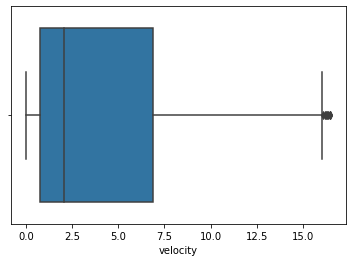

In [ ]:
# velocity

sns.boxplot(df_bus['velocity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


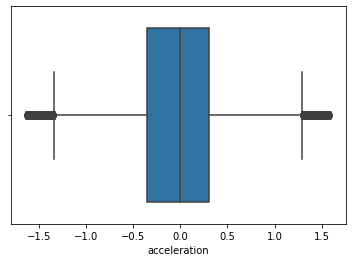

In [ ]:
#acceleration

sns.boxplot(df_bus['acceleration'])

## **4- subway**

### **4-A) box plot before omit outliers**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


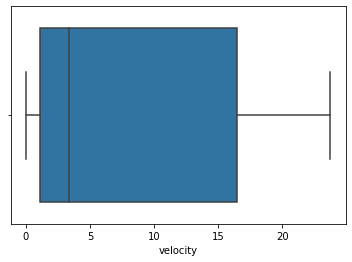

In [ ]:
# velocity

sns.boxplot(df_subway['velocity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


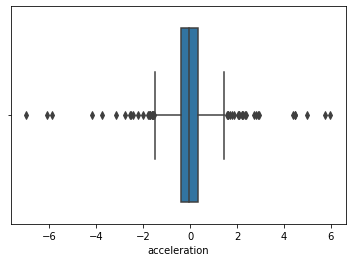

In [ ]:
# acceleration

sns.boxplot(df_subway['acceleration'])

### **4-B) IQR**

In [ ]:
df_subway = IQRmethod(df_subway,'velocity')
df_subway = IQRmethod(df_subway,'acceleration')

your dataframe has 575 records
your dataframe has 575 records after omit upper baound for velocity
your dataframe has 575 records
your dataframe has 530 records after omit upper baound for acceleration


### **4-C) z-score**

In [ ]:
df_subway = ZS(df_subway,'velocity',3)
df_subway = ZS(df_subway,'acceleration',3)

your dataframe has 530 records
your dataframe has 530 records after omit upper baound for velocity
your dataframe has 530 records
your dataframe has 530 records after omit upper baound for acceleration


### **4-D) box plot after omit outliers**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


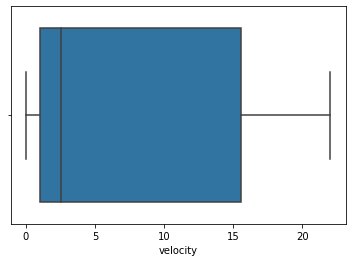

In [ ]:
# velocity

sns.boxplot(df_subway['velocity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


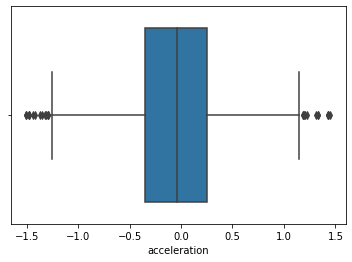

In [ ]:
# acceleration

sns.boxplot(df_subway['acceleration'])

## **5- train**

### **5-A) box plot before omit outliers**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


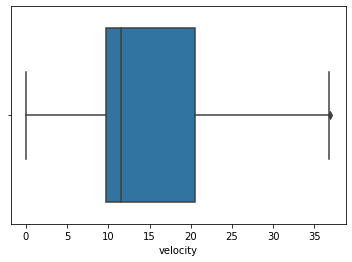

In [ ]:
# velocity

sns.boxplot(df_train['velocity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


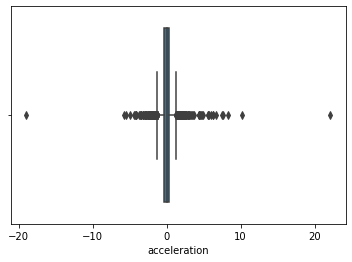

In [ ]:
# acceleration

sns.boxplot(df_train['acceleration'])

### **5-B) IQR**

In [ ]:
df_train = IQRmethod(df_train,'velocity')
df_train = IQRmethod(df_train,'acceleration')

your dataframe has 4065 records
your dataframe has 4064 records after omit upper baound for velocity
your dataframe has 4064 records
your dataframe has 3794 records after omit upper baound for acceleration


### **5-C) z-score**

In [ ]:
df_train = ZS(df_train,'velocity',3)
df_train = ZS(df_train,'acceleration',3)

your dataframe has 3794 records
your dataframe has 3794 records after omit upper baound for velocity
your dataframe has 3794 records
your dataframe has 3794 records after omit upper baound for acceleration


### **5-D) box plot after omit outliers**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


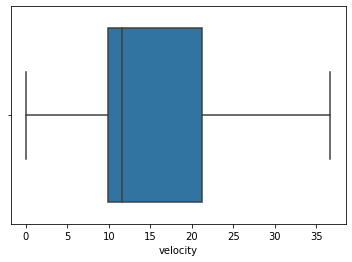

In [ ]:
# velocity

sns.boxplot(df_train['velocity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


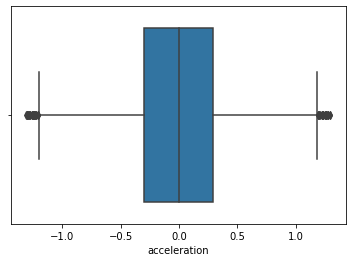

In [ ]:
# acceleration

sns.boxplot(df_train['acceleration'])

## **6- car**

### **6-A) box plot before omit outliers**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


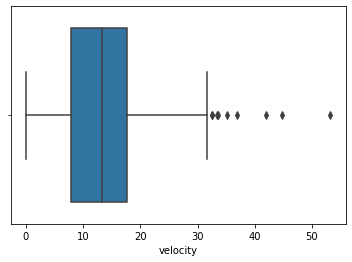

In [ ]:
# velocity

sns.boxplot(df_car['velocity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


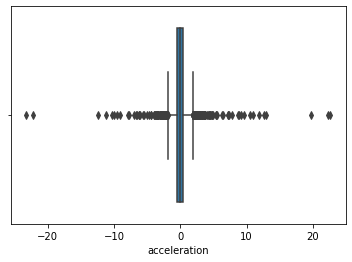

In [ ]:
# acceleration

sns.boxplot(df_car['acceleration'])

### **6-B) IQR**

In [ ]:
df_car = IQRmethod(df_car,'velocity')
df_car = IQRmethod(df_car,'acceleration')

your dataframe has 4211 records
your dataframe has 4202 records after omit upper baound for velocity
your dataframe has 4202 records
your dataframe has 3961 records after omit upper baound for acceleration


### **6-C) z-score**

In [ ]:
df_car = ZS(df_car,'velocity',3)
df_car = ZS(df_car,'acceleration',3)

your dataframe has 3961 records
your dataframe has 3961 records after omit upper baound for velocity
your dataframe has 3961 records
your dataframe has 3961 records after omit upper baound for acceleration


### **6-D) box plot after omit outliers**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


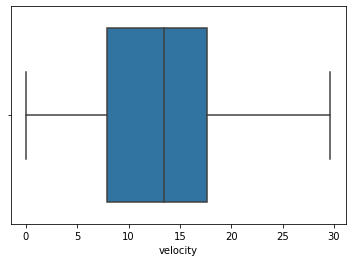

In [ ]:
# velocity

sns.boxplot(df_car['velocity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


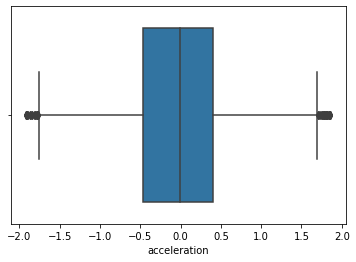

In [ ]:
# acceleration

sns.boxplot(df_car['acceleration'])

# **Visualization after removing outliers**

## **Min, Max, Mean and standard deviation for velocity and acceleration in each class**

In [ ]:
walk_velocity_max = df_walk.velocity.max()
walk_acceleration_max = df_walk.acceleration.max()
walk_acceleration_min = df_walk.acceleration.min()
walk_acceleration_mean = df_walk.acceleration.mean()
walk_velocity_mean = df_walk.velocity.mean()
walk_acceleration_std = df_walk.acceleration.std()
walk_velocity_std = df_walk.velocity.std()

bike_velocity_max = df_bike.velocity.max()
bike_acceleration_max = df_bike.acceleration.max()
bike_acceleration_min = df_bike.acceleration.min()
bike_acceleration_mean = df_bike.acceleration.mean()
bike_velocity_mean = df_bike.velocity.mean()
bike_acceleration_std = df_bike.acceleration.std()
bike_velocity_std = df_bike.velocity.std()

bus_velocity_max = df_bus.velocity.max()
bus_acceleration_max = df_bus.acceleration.max()
bus_acceleration_min = df_bus.acceleration.min()
bus_acceleration_mean = df_bus.acceleration.mean()
bus_velocity_mean = df_bus.velocity.mean()
bus_acceleration_std = df_bus.acceleration.std()
bus_velocity_std = df_bus.velocity.std()

car_velocity_max = df_car.velocity.max()
car_acceleration_max = df_car.acceleration.max()
car_acceleration_min = df_car.acceleration.min()
car_acceleration_mean = df_car.acceleration.mean()
car_velocity_mean = df_car.velocity.mean()
car_acceleration_std = df_car.acceleration.std()
car_velocity_std = df_car.velocity.std()

train_velocity_max = df_train.velocity.max()
train_acceleration_max = df_train.acceleration.max()
train_acceleration_min = df_train.acceleration.min()
train_acceleration_mean = df_train.acceleration.mean()
train_velocity_mean = df_train.velocity.mean()
train_acceleration_std = df_train.acceleration.std()
train_velocity_std = df_train.velocity.std()

subway_velocity_max = df_subway.velocity.max()
subway_acceleration_max = df_subway.acceleration.max()
subway_acceleration_min = df_subway.acceleration.min()
subway_acceleration_mean = df_subway.acceleration.mean()
subway_velocity_mean = df_subway.velocity.mean()
subway_acceleration_std = df_subway.acceleration.std()
subway_velocity_std = df_subway.velocity.std()

print('max velocity in walk dataframe :' , walk_velocity_max , '\n' , 'max acceleration in walk dataframe :' , walk_acceleration_max , '\n' ,
       'min acceleration in walk dataframe :' , walk_acceleration_min)
print('max velocity in bike dataframe :' , bike_velocity_max , '\n' , 'max acceleration in bike dataframe :' , bike_acceleration_max , '\n' ,
       'min acceleration in walk dataframe :' , bike_acceleration_min)
print('max velocity in bus dataframe :' , bus_velocity_max , '\n' , 'max acceleration in bus dataframe :' , bus_acceleration_max , '\n' ,
       'min acceleration in walk dataframe :' , bus_acceleration_min)
print('max velocity in car dataframe :' , car_velocity_max , '\n' , 'max acceleration in car dataframe :' , car_acceleration_max , '\n' ,
       'min acceleration in walk dataframe :' , car_acceleration_min)
print('max velocity in train dataframe :' , train_velocity_max , '\n' , 'max acceleration in train dataframe :' , train_acceleration_max , '\n' ,
       'min acceleration in walk dataframe :' , train_acceleration_min)
print('max velocity in subway dataframe :' , subway_velocity_max , '\n' , 'max acceleration in subway dataframe :' , subway_acceleration_max , '\n' ,
       'min acceleration in walk dataframe :' , subway_acceleration_min)

max velocity in walk dataframe : 3.438817456063122 
 max acceleration in walk dataframe : 1.1715463050514603 
 min acceleration in walk dataframe : -1.1328358089923452
max velocity in bike dataframe : 6.775867444683232 
 max acceleration in bike dataframe : 1.90441560596544 
 min acceleration in walk dataframe : -1.8709322999078557
max velocity in bus dataframe : 16.477411372594517 
 max acceleration in bus dataframe : 1.589891706813752 
 min acceleration in walk dataframe : -1.636691798496014
max velocity in car dataframe : 29.651607230964803 
 max acceleration in car dataframe : 1.8583085837877515 
 min acceleration in walk dataframe : -1.9202864581849648
max velocity in train dataframe : 36.70827801315609 
 max acceleration in train dataframe : 1.295547026663865 
 min acceleration in walk dataframe : -1.311856733868959
max velocity in subway dataframe : 22.015673274119678 
 max acceleration in subway dataframe : 1.4504555791723297 
 min acceleration in walk dataframe : -1.5073652548

### **Velocity**

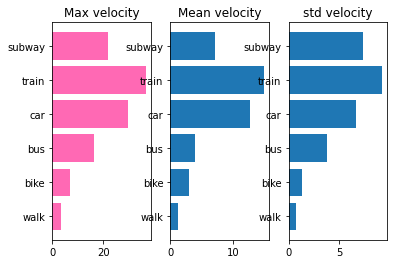

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_list = ["walk", "bike", "bus", "car", "train", "subway"]
velocity_max_list = [walk_velocity_max, bike_velocity_max, bus_velocity_max, car_velocity_max, train_velocity_max, subway_velocity_max]
velocity_mean_list = [walk_velocity_mean, bike_velocity_mean, bus_velocity_mean, car_velocity_mean, train_velocity_mean, subway_velocity_mean]
velocity_std_list = [walk_velocity_std, bike_velocity_std, bus_velocity_std, car_velocity_std, train_velocity_std, subway_velocity_std]

x = np.array(class_list)
y = np.array(velocity_max_list)
plt.subplot(1, 3, 1)
plt.title('Max velocity')
plt.barh(x,y, color="hotpink")

x = np.array(class_list)
y = np.array(velocity_mean_list)
plt.subplot(1, 3, 2)
plt.title('Mean velocity')
plt.barh(x,y)

x = np.array(class_list)
y = np.array(velocity_std_list)
plt.subplot(1, 3, 3)
plt.title('std velocity')
plt.barh(x,y)

plt.show()

### **Acceleration**

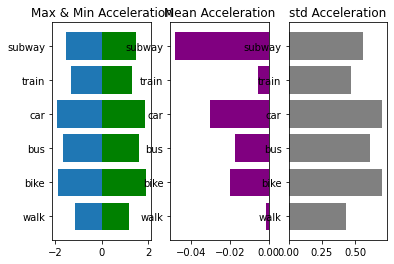

In [ ]:
acceleration_max_list = [walk_acceleration_max, bike_acceleration_max, bus_acceleration_max, car_acceleration_max, train_acceleration_max, subway_acceleration_max]
acceleration_min_list = [walk_acceleration_min, bike_acceleration_min, bus_acceleration_min, car_acceleration_min, train_acceleration_min, subway_acceleration_min]
acceleration_mean_list = [walk_acceleration_mean, bike_acceleration_mean, bus_acceleration_mean, car_acceleration_mean, train_acceleration_mean, subway_acceleration_mean]
acceleration_std_list = [walk_acceleration_std, bike_acceleration_std, bus_acceleration_std, car_acceleration_std, train_acceleration_std, subway_acceleration_std]

x = np.array(class_list)
y = np.array(acceleration_max_list)
plt.subplot(1, 3, 1)
plt.barh(x,y, color ='green')

x = np.array(class_list)
y = np.array(acceleration_min_list)
plt.plot()
plt.barh(x,y)
plt.title("Max & Min Acceleration")

x = np.array(class_list)
y = np.array(acceleration_mean_list)
plt.subplot(1, 3, 2)
plt.barh(x,y, color ='purple')
plt.title('Mean Acceleration')

x = np.array(class_list)
y = np.array(acceleration_std_list)
plt.subplot(1, 3, 3)
plt.barh(x,y, color ='gray')
plt.title('std Acceleration')

plt.show()

# **Merging all of dataframes after removing outliers**

In [ ]:
from functools import reduce

data_frames = [df_walk, df_bike, df_train, df_subway, df_bus, df_car]

df_merged = pd.concat([df_walk, df_bike, df_train, df_subway, df_bus, df_car])

In [ ]:
after_outlier = len(df_merged.index.unique())
print('Our dataframe decrease to' , after_outlier, 'from', before_outlier)


Our dataframe decrease to 21258 from 21991
